This notebook creates synthetic data with 2 different rates, make igram pairs and show that it gives a TPC bias. 

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from scipy import signal
%matplotlib  widget 

In [2]:
seismic2 = plt.cm.get_cmap("seismic").copy()
seismic2.set_bad(color='green')
print('colormap made where NANs will be green.')

colormap made where NANs will be green.


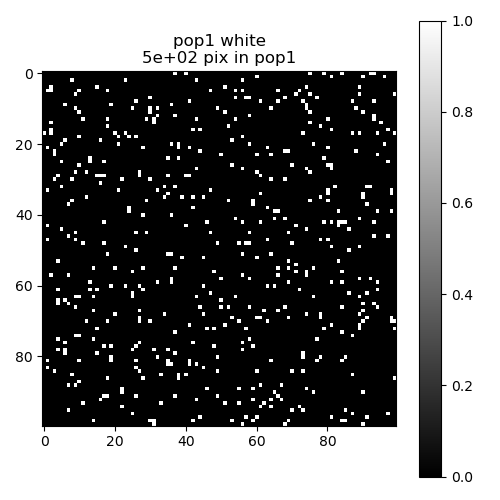

In [17]:
dx = 100
dy = 100
pop1_percent = 5
med = 0.0
std = 2.0

random_vals = np.random.normal(med,std,(dx,dy)) # median, std, size of array
mask = np.zeros((dx,dy))
mask[random_vals<np.percentile(random_vals.flatten(),pop1_percent)] = 1.0

plt.figure(figsize=(5,5),tight_layout=True)
plt.imshow(mask,cmap='gray',interpolation='none')
plt.colorbar(); plt.title('pop1 white\n'+str(np.sum(mask))+' pix in pop1')
plt.show()


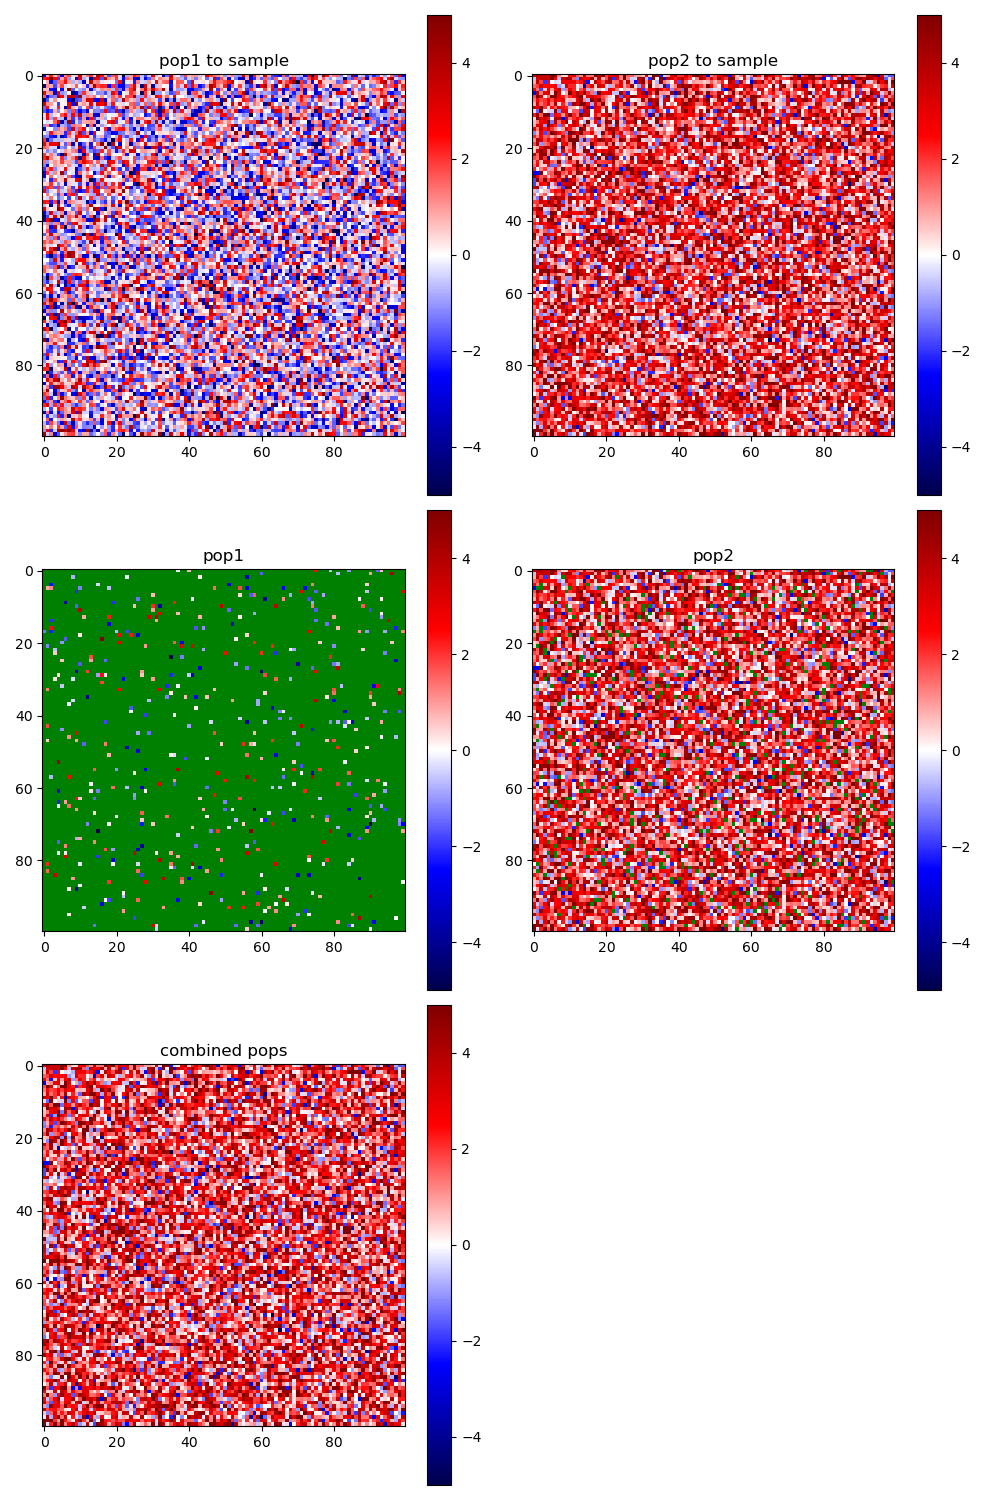

In [18]:
pop1_vel = 0.0
pop2_vel = 2.0

pop1_to_sample = np.random.normal(pop1_vel,2.0,(dy,dx))
pop2_to_sample = np.random.normal(pop2_vel,2.0,(dy,dx))
pop1 = np.zeros((dy,dx))*np.nan
pop1[mask==1]=pop1_to_sample[mask==1]
pop2 = np.zeros((dy,dx))*np.nan
pop2[mask==0]=pop2_to_sample[mask==0]

pops12 = np.zeros((dy,dx))*np.nan
pops12[mask==1]=pop1_to_sample[mask==1]
pops12[mask==0]=pop2_to_sample[mask==0]

plt.figure(figsize=(10,15),tight_layout=True)
plt.subplot(3,2,1)
plt.imshow(pop1_to_sample,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('pop1 to sample')
plt.subplot(3,2,2)
plt.imshow(pop2_to_sample,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('pop2 to sample')
plt.subplot(3,2,3)
plt.imshow(pop1,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('pop1')
plt.subplot(3,2,4)
plt.imshow(pop2,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('pop2')
plt.subplot(3,2,5)
plt.imshow(pops12,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('combined pops')
plt.show()

Write a function that creates a combined pops array on demand. 

In [19]:
def pops12(dy,dx,pop1_percent,pop1_vel,pop2_vel,vel_std):
    med = 0.0
    std = 2.0
    random_vals = np.random.normal(med,std,(dx,dy)) # median, std, size of array
    mask = np.zeros((dx,dy))
    mask[random_vals<np.percentile(random_vals.flatten(),pop1_percent)] = 1.0

    pop1_to_sample = np.random.normal(pop1_vel,vel_std,(dy,dx))
    pop2_to_sample = np.random.normal(pop2_vel,vel_std,(dy,dx))
    pop1 = np.zeros((dy,dx))*np.nan
    pop1[mask==1]=pop1_to_sample[mask==1]
    pop2 = np.zeros((dy,dx))*np.nan
    pop2[mask==0]=pop2_to_sample[mask==0]

    pops12 = np.zeros((dy,dx))*np.nan
    pops12[mask==1]=pop1_to_sample[mask==1]
    pops12[mask==0]=pop2_to_sample[mask==0]

    return pops12

Test the function.

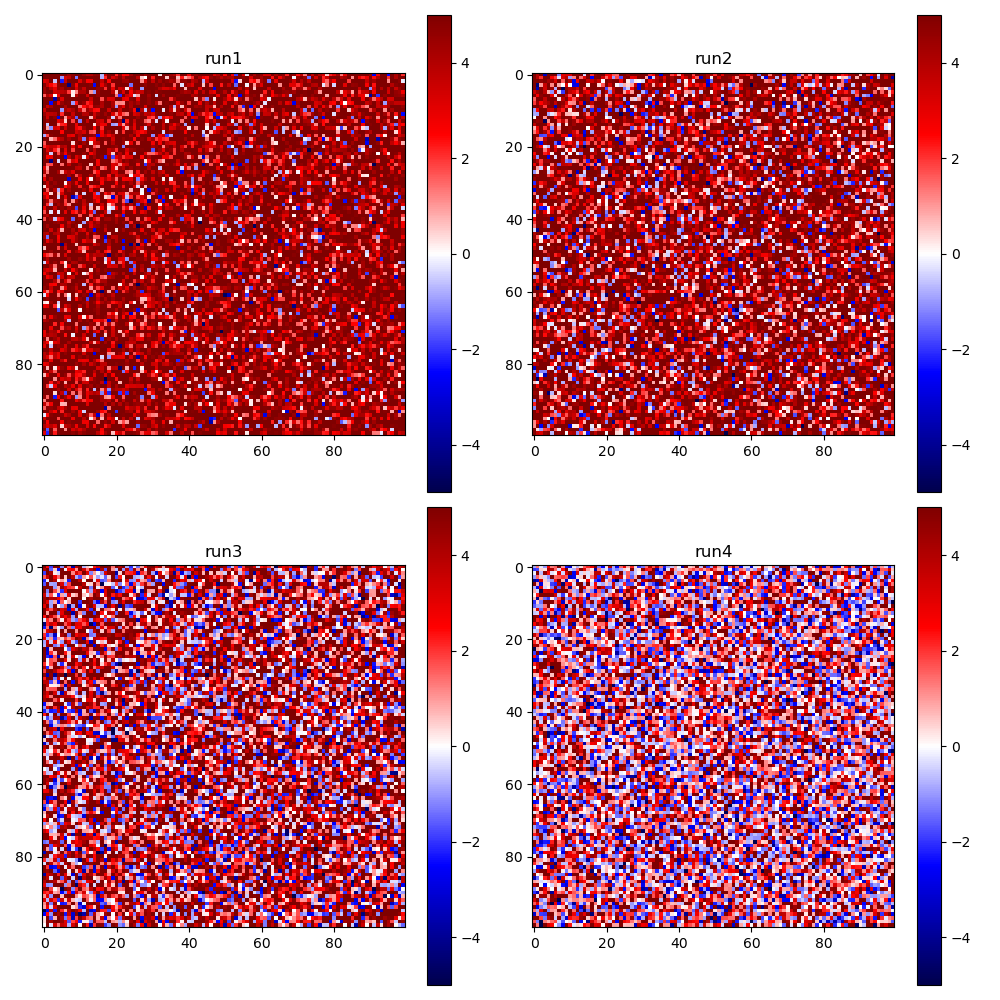

In [20]:
dy = 100
dx = 100
pop1_percent = 75
pop1_vel = 0.0
pop2_vel = 5.0
vel_std = 2.0

pops12_run1 = pops12(dy,dx,10,pop1_vel,pop2_vel,vel_std)
pops12_run2 = pops12(dy,dx,25,pop1_vel,pop2_vel,vel_std)
pops12_run3 = pops12(dy,dx,50,pop1_vel,pop2_vel,vel_std)
pops12_run4 = pops12(dy,dx,75,pop1_vel,pop2_vel,vel_std)

plt.figure(figsize=(10,10),tight_layout=True)
plt.subplot(2,2,1)
plt.imshow(pops12_run1,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('run1')
plt.subplot(2,2,2)
plt.imshow(pops12_run2,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('run2')
plt.subplot(2,2,3)
plt.imshow(pops12_run3,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('run3')
plt.subplot(2,2,4)
plt.imshow(pops12_run4,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('run4')
plt.show()

Create a single triplet. 

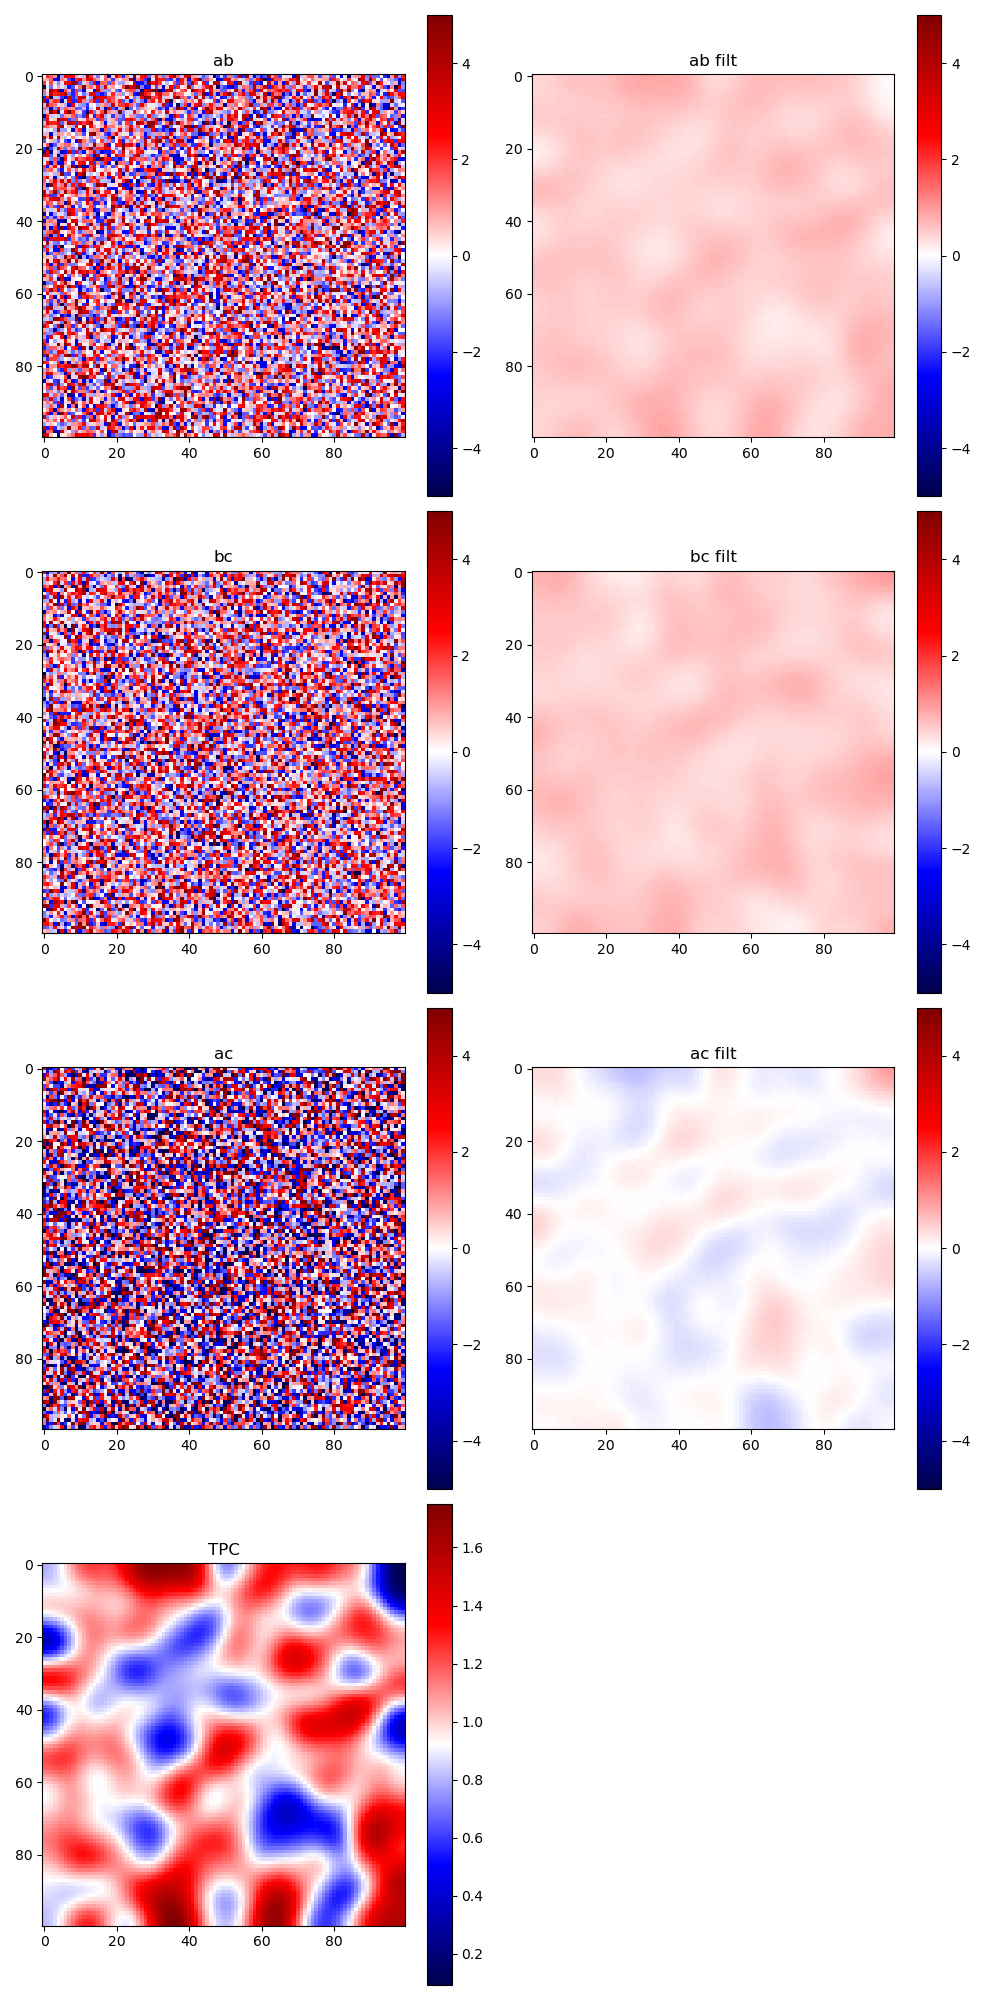

In [21]:
dy = 100
dx = 100
pop1_percent = 75
pop1_vel = 0.0
pop2_vel = 2.0
vel_std = 2.0
# filter size
xlooks = 10
ylooks = 10


ab = pops12(dy,dx,pop1_percent,pop1_vel,pop2_vel,vel_std)
bc = pops12(dy,dx,pop1_percent,pop1_vel,pop2_vel,vel_std)
ac = bc-ab
# now filter them to calculate TPC
ab_filt = gaussian_filter(ab,sigma=[xlooks/2,ylooks/2])
bc_filt = gaussian_filter(bc,sigma=[xlooks/2,ylooks/2])
ac_filt = gaussian_filter(ac,sigma=[xlooks/2,ylooks/2])
# calculate temp TPC
temp_TPC = ab_filt+bc_filt-ac_filt

plt.figure(figsize=(10,20),tight_layout=True)
plt.subplot(4,2,1)
plt.imshow(ab,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('ab')
plt.subplot(4,2,2)
plt.imshow(ab_filt,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('ab filt')
plt.subplot(4,2,3)
plt.imshow(bc,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('bc')
plt.subplot(4,2,4)
plt.imshow(bc_filt,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('bc filt')
plt.subplot(4,2,5)
plt.imshow(ac,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('ac')
plt.subplot(4,2,6)
plt.imshow(ac_filt,cmap=seismic2,interpolation='none',vmin=-5,vmax=5)
plt.colorbar(); plt.title('ac filt')
plt.subplot(4,2,7)
plt.imshow(temp_TPC,cmap=seismic2,interpolation='none')
plt.colorbar(); plt.title('TPC')
plt.show()

Loop over a bunch of triplets, make 2pops for each igram (a-b, b-c, then subtract at full res for a-c), filter all three and calculate TPC, add it to the cumulative TPC array. 

In [22]:
cum_TPC = np.zeros((dy,dx))
dy = 100
dx = 100
pop1_percent = 0.01
pop1_vel = 0.0
pop2_vel = 3.0
vel_std = 2.0
# filter size
xlooks = 10
ylooks = 10

for i in range(100): # start with 100 triplets
    ab = pops12(dy,dx,pop1_percent,pop1_vel,pop2_vel,vel_std)
    bc = pops12(dy,dx,pop1_percent,pop1_vel,pop2_vel,vel_std)
    ac = bc-ab
    # now filter them to calculate TPC
    ab_filt = gaussian_filter(ab,sigma=[xlooks/2,ylooks/2])
    bc_filt = gaussian_filter(bc,sigma=[xlooks/2,ylooks/2])
    ac_filt = gaussian_filter(ac,sigma=[xlooks/2,ylooks/2])
    # calculate temp TPC
    temp_TPC = ab_filt+bc_filt-ac_filt

    cum_TPC = cum_TPC + temp_TPC

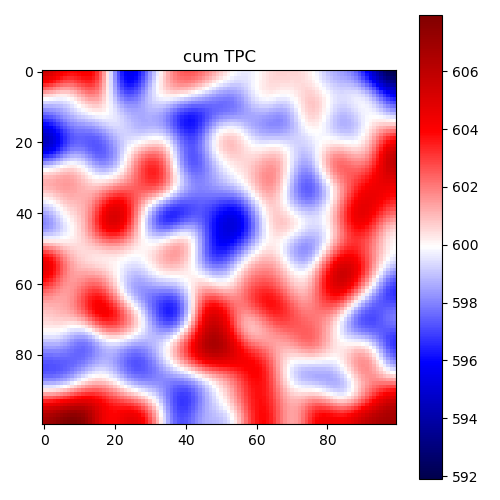

In [23]:
plt.figure(figsize=(5,5),tight_layout=True)
plt.imshow(cum_TPC,cmap=seismic2,interpolation='none')
plt.colorbar(); plt.title('cum TPC')
plt.show()